In [6]:
#!pip install pytorch-transformers
#use latest version of transformers instead of pytorch-transformers
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, RobertaTokenizer, RobertaForMaskedLM

# load tokenizer and pretrained model(Bert)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForMaskedLM.from_pretrained('bert-base-cased')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaForMaskedLM.from_pretrained('roberta-base')
model.eval()



In [8]:
def predictMask_single(text, masked_index, k):

  tokenized_text = tokenizer.tokenize(text)
  

  # mask the text
  tokenized_text[masked_index] = '[MASK]'
  tokenized_text.insert(0,'[CLS]')
  tokenized_text.append('[SEP]')
  print("masked text: ")
  print(tokenized_text)

  # tokenizie
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  encoded_dict = tokenizer(text)

  # convert to tensor
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor(encoded_dict['token_type_ids'])

  # put on cuda
  tokens_tensor = tokens_tensor.to('cuda')
  segments_tensors = segments_tensors.to('cuda')
  model.to('cuda')

  # predict
  with torch.no_grad():
      outputs = model(tokens_tensor, token_type_ids=segments_tensors)
      predictions = outputs[0]

  # decode
  #predicted_index = torch.argmax(predictions[0, masked_index]).item()
  predicted_indexes = torch.topk(predictions[0, masked_index + 1], k)
  top_k_tokens = zip(predicted_indexes.indices.tolist(), predicted_indexes.values.tolist())
  for token, score in top_k_tokens:
    print(tokenizer.convert_ids_to_tokens([token])[0], f"(score: {score})")

In [10]:
text = "Someone winds up [MASK] right arm and knocks the fighter down with a haymaker."
mask_id = 3
topK = 10

predictMask_single(text, mask_id, topK)




masked text: 
['[CLS]', 'Someone', 'winds', 'up', '[MASK]', 'right', 'arm', 'and', 'knocks', 'the', 'fighter', 'down', 'with', 'a', 'hay', '##maker', '.', '[SEP]']
his (score: 14.17838191986084)
the (score: 12.609306335449219)
my (score: 12.085245132446289)
her (score: 11.304217338562012)
their (score: 10.660741806030273)
its (score: 10.465651512145996)
a (score: 10.252102851867676)
in (score: 9.056526184082031)
your (score: 8.616687774658203)
our (score: 8.13196849822998)


In [11]:
def predict_single_without_id(text, k):

  tokenized_text = tokenizer.tokenize(text)

  masked_index = tokenized_text.index('[MASK]')

  # mask the text
  tokenized_text[masked_index] = '[MASK]'
  tokenized_text.insert(0,'[CLS]')
  tokenized_text.append('[SEP]')
  #print("masked text: ")
  #print(tokenized_text)

  # tokenizie
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  encoded_dict = tokenizer(text)

  # convert to tensor
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor(encoded_dict['token_type_ids'])

  # put on cuda
  tokens_tensor = tokens_tensor.to('cuda')
  segments_tensors = segments_tensors.to('cuda')
  model.to('cuda')

  # predict
  with torch.no_grad():
      outputs = model(tokens_tensor, token_type_ids=segments_tensors)
      predictions = outputs[0]

  # decode
  #predicted_index = torch.argmax(predictions[0, masked_index]).item()
  predicted_indexes = torch.topk(predictions[0, masked_index + 1], k)
  top_k_tokens = zip(predicted_indexes.indices.tolist(), predicted_indexes.values.tolist())
  top_k = []
  for token, score in top_k_tokens:
    top_k.append((tokenizer.convert_ids_to_tokens([token])[0], round(score, 3)))
    #print(tokenizer.convert_ids_to_tokens([token])[0], f"(score: {score})")
  return top_k

In [14]:
line = "The belly dancer dances on stage shaking with [MASK] hips and body."
print(predict_single_without_id(line, 5))


[('her', 14.233), ('his', 13.188), ('the', 12.566), ('its', 11.525), ('both', 11.188)]


In [ ]:
def get_bias_ratio(top_k):
  male_token = ["he", "his", "him", "himself", "cowboy", "cowboys", "male", "males", "father", "grandfather", "dad", "daddy" ,"son", "grandson", "man", "men", "waiter", "waiters", "gentleman", "gentlemen", "boy", "boys", "mr", "actor", "actors", "husband", "boyfriend", "brother", "brothers", "uncle", "uncles", "guy", "guys"]
  female_token = ["she", "her", "hers", "herself", "witch", "witches", "female", "females", "mother", "grandmother", "mom", "mum", "mommy", "daughter", "granddaughter", "woman", "women", "waitress", "waitresses", "lady", "ladies", "girl", "girls", "miss", "mrs", "actress", "actresses", "wife", "girlfriend", "sister", "sisters", "aunt", "aunts", "beauty"] 
  max_male_token = 'None'
  max_female_token = 'None'
  max_male_score = 0
  max_female_score = 0
  for token, score in top_k:
    if token in male_token:
      max_male_token = token
      max_male_score = score
      break
  for token, score in top_k:
    if token in female_token:
      max_female_token = token
      max_female_score = score
      break
  ratio = 0
  #if max_male_score > max_female_score:
  if max_male_token == 'None' and max_female_token == 'None':
    #print("no solution\n")
    return [0, 0];
  if max_male_score > max_female_score and max_female_score > 5:
    ratio = round(max_male_score / (max_female_score + max_male_score), 3)
    #print('Male dominates: bias score = {} with {} = {} and {} = {}\n'.format(ratio, max_male_token, max_male_score, max_female_token, max_female_score))
    print(ratio)
    scores.append(ratio)
    return [ratio, 0]
  elif max_male_score < max_female_score and max_male_score > 5:
    ratio = round(max_female_score / (max_female_score + max_male_score), 3)
    #print('Female dominates: bias score = {} with {} = {} and {} = {}\n'.format(1-ratio, max_female_token, max_female_score, max_male_token, max_male_score))
    print(1-ratio)
    scores.append(1-ratio)
    return [ratio, 1]
  return [0,0]


In [ ]:
def getAverageRatio(input):
  #out = open(/content/"distribution.txt", "w")
  with open(input, 'r') as f:
    lines = f.readlines()
    male_count = 0
    max_male_ratio = 0
    sum_male_ratio = 0
    female_count = 0
    no_bias_count = 0
    max_female_ratio = 0
    sum_female_ratio = 0
    for line in lines:
      #print(line[0:-1])
      k = 10
      top_prediction = predict_single_without_id(line, k)
      ratio = get_bias_ratio(top_prediction)
      if ratio[0] != 0:
        if ratio[1] == 0:
          sum_male_ratio += ratio[0]
          male_count += 1
          if ratio[0] > max_male_ratio:
            max_male_ratio = ratio[0]
            max_male = line[0:-1]
        else:
          sum_female_ratio += ratio[0]
          female_count += 1
          if ratio[0] > max_female_ratio:
            max_female_ratio = ratio[0]
            max_female = line[0:-1]
    
    print("Total sentence: ", len(lines))
    print("Male count: ", male_count)
    print("Female count: ", female_count)
    print("Most biased to male: ", max_male, "  Ratio = ", max_male_ratio)
    print("Most biased to female: ", max_female, "  Ratio = ", 1-max_female_ratio)
    return [sum_male_ratio/male_count, sum_female_ratio/female_count]

In [ ]:
male_dom, female_dom = getAverageRatio("/content/train_full_filtered.txt")
print("When male dominates: ", male_dom)
print("When female dominates: ", 1-female_dom)

[0.519, 0.564, 0.628, 0.507, 0.523, 0.522, 0.58, 0.564, 0.564, 0.585, 0.543, 0.543, 0.546, 0.504, 0.514, 0.532, 0.518, 0.543, 0.577, 0.521, 0.552, 0.555, 0.547, 0.556, 0.537, 0.6, 0.495, 0.526, 0.551, 0.563, 0.536, 0.541, 0.531, 0.564, 0.52, 0.502, 0.544, 0.549, 0.552, 0.506, 0.539, 0.594, 0.521, 0.563, 0.496, 0.48, 0.505, 0.563, 0.55, 0.583, 0.552, 0.485, 0.574, 0.508, 0.511, 0.58, 0.586, 0.547, 0.585, 0.548, 0.582, 0.531, 0.527, 0.511, 0.43799999999999994, 0.43799999999999994, 0.591, 0.554, 0.58, 0.558, 0.556, 0.534, 0.477, 0.506, 0.558, 0.518, 0.535, 0.529, 0.578, 0.564, 0.565, 0.537, 0.523, 0.598, 0.503, 0.544, 0.596, 0.544, 0.562, 0.49, 0.545, 0.575, 0.501, 0.509, 0.555, 0.529, 0.556, 0.594, 0.6, 0.535, 0.57, 0.563, 0.573, 0.541, 0.571, 0.532, 0.566, 0.521, 0.518, 0.577, 0.537, 0.496, 0.538, 0.522, 0.603, 0.556, 0.556, 0.526, 0.554, 0.511, 0.563, 0.552, 0.53, 0.532, 0.627, 0.554, 0.503, 0.495, 0.552, 0.604, 0.575, 0.596, 0.601, 0.526, 0.514, 0.58, 0.509, 0.541, 0.561, 0.531, 0.541

Text(0.5, 1.0, 'Histogram of BERT-uncased:')

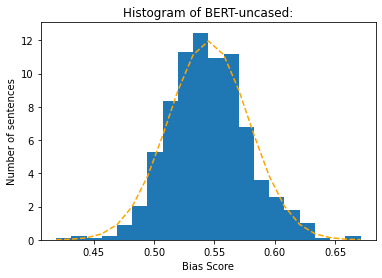

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
scores1 = [0.513, 0.567, 0.575, 0.483, 0.485, 0.521, 0.519, 0.596, 0.55, 0.55, 0.6, 0.567, 0.585, 0.521, 0.501, 0.541, 0.537, 0.592, 0.539, 0.608, 0.54, 0.536, 0.576, 0.576, 0.543, 0.542, 0.62, 0.488, 0.547, 0.649, 0.591, 0.57, 0.569, 0.524, 0.589, 0.45399999999999996, 0.483, 0.518, 0.549, 0.585, 0.513, 0.557, 0.582, 0.532, 0.577, 0.518, 0.44499999999999995, 0.45599999999999996, 0.531, 0.543, 0.589, 0.524, 0.519, 0.598, 0.544, 0.491, 0.56, 0.61, 0.542, 0.602, 0.547, 0.505, 0.595, 0.524, 0.524, 0.524, 0.504, 0.42400000000000004, 0.42400000000000004, 0.622, 0.539, 0.569, 0.569, 0.623, 0.521, 0.485, 0.45199999999999996, 0.552, 0.522, 0.538, 0.562, 0.627, 0.576, 0.612, 0.54, 0.487, 0.619, 0.538, 0.538, 0.6, 0.538, 0.581, 0.478, 0.528, 0.589, 0.523, 0.522, 0.542, 0.543, 0.579, 0.567, 0.528, 0.53, 0.57, 0.55, 0.591, 0.529, 0.521, 0.517, 0.583, 0.514, 0.509, 0.582, 0.578, 0.512, 0.544, 0.553, 0.582, 0.559, 0.559, 0.52, 0.54, 0.516, 0.573, 0.578, 0.504, 0.601, 0.618, 0.572, 0.525, 0.546, 0.574, 0.564, 0.549, 0.624, 0.584, 0.565, 0.53, 0.577, 0.534, 0.543, 0.626, 0.56, 0.593, 0.549, 0.593, 0.483, 0.588, 0.551, 0.571, 0.561, 0.548, 0.495, 0.599, 0.58, 0.496, 0.52, 0.52, 0.527, 0.52, 0.575, 0.547, 0.527, 0.587, 0.56, 0.516, 0.497, 0.527, 0.505, 0.587, 0.561, 0.582, 0.559, 0.552, 0.554, 0.557, 0.484, 0.561, 0.537, 0.544, 0.542, 0.562, 0.561, 0.561, 0.548, 0.596, 0.574, 0.561, 0.527, 0.511, 0.579, 0.483, 0.615, 0.545, 0.509, 0.571, 0.491, 0.485, 0.499, 0.539, 0.535, 0.629, 0.56, 0.522, 0.516, 0.64, 0.516, 0.554, 0.537, 0.49, 0.554, 0.569, 0.571, 0.557, 0.571, 0.526, 0.43999999999999995, 0.42200000000000004, 0.537, 0.526, 0.6, 0.544, 0.552, 0.626, 0.546, 0.535, 0.535, 0.546, 0.647, 0.567, 0.46599999999999997, 0.559, 0.526, 0.566, 0.606, 0.572, 0.526, 0.606, 0.525, 0.52, 0.512, 0.55, 0.531, 0.536, 0.523, 0.584, 0.592, 0.572, 0.569, 0.579, 0.482, 0.476, 0.505, 0.504, 0.637, 0.601, 0.601, 0.525, 0.512, 0.527, 0.527, 0.597, 0.508, 0.534, 0.514, 0.586, 0.493, 0.513, 0.549, 0.618, 0.585, 0.576, 0.618, 0.575, 0.576, 0.57, 0.538, 0.469, 0.576, 0.504, 0.538, 0.555, 0.598, 0.545, 0.546, 0.536, 0.51, 0.566, 0.531, 0.573, 0.496, 0.61, 0.557, 0.519, 0.507, 0.47, 0.494, 0.593, 0.607, 0.486, 0.496, 0.499, 0.571, 0.551, 0.605, 0.587, 0.592, 0.595, 0.591, 0.534, 0.501, 0.539, 0.591, 0.543, 0.49, 0.6, 0.481, 0.512, 0.563, 0.645, 0.524, 0.43899999999999995, 0.569, 0.521, 0.481, 0.571, 0.558, 0.543, 0.593, 0.587, 0.589, 0.561, 0.552, 0.527, 0.549, 0.45899999999999996, 0.523, 0.512, 0.553, 0.531, 0.536, 0.523, 0.528, 0.615, 0.549, 0.598, 0.512, 0.584, 0.526, 0.505, 0.47, 0.543, 0.578, 0.589, 0.575, 0.583, 0.524, 0.561, 0.583, 0.561, 0.544, 0.604, 0.596, 0.594, 0.52, 0.534, 0.509, 0.544, 0.544, 0.547, 0.534, 0.527, 0.508, 0.576, 0.554, 0.553, 0.576, 0.508, 0.581, 0.541, 0.592, 0.529, 0.594, 0.542, 0.546, 0.498, 0.509, 0.571, 0.569, 0.581, 0.558, 0.576, 0.499, 0.581, 0.582, 0.568, 0.46699999999999997, 0.5, 0.582, 0.545, 0.522, 0.585, 0.626, 0.526, 0.44299999999999995, 0.539, 0.58, 0.583, 0.59, 0.588, 0.482, 0.534, 0.533, 0.507, 0.591, 0.64, 0.641, 0.579, 0.44699999999999995, 0.545, 0.545, 0.525, 0.527, 0.42900000000000005, 0.568, 0.57, 0.53, 0.535, 0.628, 0.555, 0.485, 0.564, 0.602, 0.641, 0.47, 0.535, 0.55, 0.636, 0.596, 0.524, 0.561, 0.554, 0.582, 0.614, 0.557, 0.489, 0.591, 0.584, 0.548, 0.518, 0.511, 0.519, 0.526, 0.516, 0.5, 0.53, 0.536, 0.501, 0.555, 0.572, 0.558, 0.552, 0.641, 0.546, 0.574, 0.543, 0.556, 0.567, 0.538, 0.557, 0.593, 0.501, 0.503, 0.621, 0.563, 0.535, 0.553, 0.476, 0.46099999999999997, 0.472, 0.602, 0.497, 0.615, 0.525, 0.59, 0.547, 0.584, 0.568, 0.562, 0.53, 0.512, 0.51, 0.618, 0.512, 0.522, 0.587, 0.607, 0.534, 0.611, 0.541, 0.562, 0.554, 0.59, 0.496, 0.619, 0.538, 0.556, 0.559, 0.534, 0.56, 0.541, 0.575, 0.626, 0.555, 0.573, 0.548, 0.513, 0.564, 0.562, 0.584, 0.584, 0.562, 0.535, 0.613, 0.528, 0.516, 0.557, 0.537, 0.528, 0.547, 0.485, 0.478, 0.562, 0.539, 0.486, 0.528, 0.546, 0.547, 0.546, 0.593, 0.59, 0.524, 0.484, 0.55, 0.541, 0.518, 0.651, 0.567, 0.575, 0.522, 0.515, 0.604, 0.534, 0.573, 0.55, 0.607, 0.578, 0.532, 0.591, 0.546, 0.569, 0.598, 0.501, 0.526, 0.544, 0.573, 0.534, 0.598, 0.562, 0.503, 0.491, 0.571, 0.54, 0.576, 0.615, 0.542, 0.569, 0.531, 0.519, 0.585, 0.503, 0.588, 0.52, 0.542, 0.547, 0.565, 0.511, 0.607, 0.525, 0.531, 0.552, 0.626, 0.569, 0.556, 0.601, 0.568, 0.537, 0.558, 0.532, 0.58, 0.544, 0.565, 0.592, 0.52, 0.527, 0.561, 0.614, 0.561, 0.53, 0.546, 0.54, 0.47, 0.515, 0.505, 0.515, 0.567, 0.528, 0.503, 0.535, 0.491, 0.601, 0.536, 0.524]
scores2 = [0.519, 0.564, 0.628, 0.507, 0.523, 0.522, 0.58, 0.564, 0.564, 0.585, 0.543, 0.543, 0.546, 0.504, 0.514, 0.532, 0.518, 0.543, 0.577, 0.521, 0.552, 0.555, 0.547, 0.556, 0.537, 0.6, 0.495, 0.526, 0.551, 0.563, 0.536, 0.541, 0.531, 0.564, 0.52, 0.502, 0.544, 0.549, 0.552, 0.506, 0.539, 0.594, 0.521, 0.563, 0.496, 0.48, 0.505, 0.563, 0.55, 0.583, 0.552, 0.485, 0.574, 0.508, 0.511, 0.58, 0.586, 0.547, 0.585, 0.548, 0.582, 0.531, 0.527, 0.511, 0.43799999999999994, 0.43799999999999994, 0.591, 0.554, 0.58, 0.558, 0.556, 0.534, 0.477, 0.506, 0.558, 0.518, 0.535, 0.529, 0.578, 0.564, 0.565, 0.537, 0.523, 0.598, 0.503, 0.544, 0.596, 0.544, 0.562, 0.49, 0.545, 0.575, 0.501, 0.509, 0.555, 0.529, 0.556, 0.594, 0.6, 0.535, 0.57, 0.563, 0.573, 0.541, 0.571, 0.532, 0.566, 0.521, 0.518, 0.577, 0.537, 0.496, 0.538, 0.522, 0.603, 0.556, 0.556, 0.526, 0.554, 0.511, 0.563, 0.552, 0.53, 0.532, 0.627, 0.554, 0.503, 0.495, 0.552, 0.604, 0.575, 0.596, 0.601, 0.526, 0.514, 0.58, 0.509, 0.541, 0.561, 0.531, 0.541, 0.545, 0.59, 0.494, 0.558, 0.555, 0.557, 0.523, 0.576, 0.485, 0.538, 0.565, 0.537, 0.499, 0.527, 0.519, 0.528, 0.577, 0.558, 0.533, 0.578, 0.528, 0.529, 0.524, 0.545, 0.563, 0.604, 0.56, 0.567, 0.566, 0.522, 0.547, 0.538, 0.498, 0.578, 0.524, 0.533, 0.534, 0.558, 0.56, 0.568, 0.558, 0.574, 0.551, 0.568, 0.533, 0.564, 0.644, 0.48, 0.568, 0.552, 0.521, 0.53, 0.512, 0.498, 0.513, 0.53, 0.63, 0.551, 0.515, 0.535, 0.663, 0.535, 0.561, 0.543, 0.515, 0.542, 0.592, 0.56, 0.541, 0.561, 0.508, 0.505, 0.471, 0.537, 0.518, 0.584, 0.544, 0.58, 0.631, 0.58, 0.519, 0.519, 0.58, 0.597, 0.557, 0.514, 0.538, 0.541, 0.611, 0.609, 0.559, 0.541, 0.609, 0.54, 0.51, 0.519, 0.535, 0.529, 0.531, 0.523, 0.562, 0.554, 0.536, 0.555, 0.59, 0.506, 0.483, 0.509, 0.671, 0.532, 0.532, 0.528, 0.552, 0.552, 0.512, 0.559, 0.488, 0.514, 0.523, 0.554, 0.494, 0.511, 0.528, 0.592, 0.597, 0.571, 0.592, 0.553, 0.571, 0.543, 0.535, 0.562, 0.5, 0.556, 0.544, 0.574, 0.572, 0.585, 0.517, 0.534, 0.561, 0.486, 0.529, 0.494, 0.564, 0.539, 0.517, 0.486, 0.492, 0.578, 0.57, 0.513, 0.49, 0.496, 0.57, 0.54, 0.577, 0.568, 0.607, 0.606, 0.616, 0.541, 0.518, 0.546, 0.561, 0.524, 0.479, 0.562, 0.533, 0.529, 0.546, 0.626, 0.55, 0.489, 0.551, 0.521, 0.501, 0.563, 0.549, 0.536, 0.56, 0.579, 0.595, 0.554, 0.559, 0.521, 0.548, 0.491, 0.497, 0.546, 0.543, 0.578, 0.516, 0.511, 0.602, 0.542, 0.592, 0.526, 0.594, 0.532, 0.5, 0.529, 0.513, 0.59, 0.559, 0.537, 0.588, 0.519, 0.563, 0.546, 0.575, 0.537, 0.571, 0.537, 0.567, 0.519, 0.546, 0.574, 0.545, 0.537, 0.536, 0.524, 0.525, 0.522, 0.52, 0.518, 0.542, 0.52, 0.542, 0.558, 0.579, 0.531, 0.6, 0.575, 0.565, 0.565, 0.508, 0.548, 0.531, 0.579, 0.591, 0.579, 0.509, 0.532, 0.566, 0.557, 0.57, 0.565, 0.503, 0.571, 0.542, 0.506, 0.523, 0.585, 0.619, 0.559, 0.46399999999999997, 0.547, 0.55, 0.568, 0.57, 0.614, 0.519, 0.46399999999999997, 0.551, 0.528, 0.528, 0.558, 0.61, 0.614, 0.552, 0.496, 0.538, 0.531, 0.522, 0.531, 0.41900000000000004, 0.536, 0.567, 0.538, 0.528, 0.608, 0.521, 0.513, 0.527, 0.579, 0.633, 0.45099999999999996, 0.512, 0.505, 0.539, 0.612, 0.508, 0.532, 0.547, 0.561, 0.619, 0.561, 0.497, 0.571, 0.557, 0.532, 0.521, 0.512, 0.537, 0.561, 0.509, 0.473, 0.554, 0.484, 0.504, 0.541, 0.558, 0.545, 0.544, 0.576, 0.55, 0.598, 0.546, 0.545, 0.551, 0.505, 0.549, 0.535, 0.508, 0.527, 0.615, 0.552, 0.523, 0.538, 0.534, 0.494, 0.506, 0.582, 0.511, 0.587, 0.512, 0.584, 0.565, 0.549, 0.556, 0.56, 0.512, 0.528, 0.503, 0.588, 0.527, 0.522, 0.633, 0.579, 0.545, 0.538, 0.587, 0.518, 0.56, 0.54, 0.573, 0.507, 0.615, 0.563, 0.55, 0.546, 0.531, 0.543, 0.541, 0.561, 0.631, 0.544, 0.573, 0.536, 0.541, 0.561, 0.579, 0.598, 0.598, 0.579, 0.531, 0.519, 0.529, 0.537, 0.52, 0.497, 0.537, 0.512, 0.471, 0.592, 0.519, 0.535, 0.496, 0.515, 0.542, 0.511, 0.542, 0.573, 0.546, 0.516, 0.566, 0.557, 0.526, 0.561, 0.529, 0.575, 0.51, 0.502, 0.568, 0.532, 0.541, 0.561, 0.553, 0.528, 0.54, 0.558, 0.549, 0.545, 0.569, 0.615, 0.525, 0.525, 0.542, 0.542, 0.544, 0.583, 0.538, 0.511, 0.526, 0.564, 0.536, 0.568, 0.615, 0.553, 0.548, 0.544, 0.537, 0.522, 0.565, 0.528, 0.6, 0.507, 0.546, 0.559, 0.536, 0.497, 0.561, 0.516, 0.55, 0.574, 0.547, 0.571, 0.595, 0.562, 0.53, 0.518, 0.578, 0.535, 0.542, 0.518, 0.548, 0.534, 0.534, 0.562, 0.573, 0.562, 0.547, 0.54, 0.517, 0.511, 0.505, 0.517, 0.505, 0.579, 0.57, 0.529, 0.542, 0.502, 0.552, 0.543, 0.548]
print(scores)
fig, ax = plt.subplots()
mu = np.mean(scores)
sigma = np.std(scores)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--', color = 'orange')
n, bins, patches = ax.hist(scores, 20, density=1)
ax.set_xlabel('Bias Score')
ax.set_ylabel('Number of sentences')
ax.set_title('Histogram of BERT-uncased:')